# Approximate single value decomposition

The aproximate implementation works by:
* binned the movie in 1 s bins (per channel)
* Estimating U from the binned movie.
* Iterating over the raw data to estimate S.VT 

Details in wfield-tools/decomposition.py 


In [1]:
from wfieldtools import *

localdisk = 'd:\\temp_folder'
dat_path = glob(pjoin(localdisk,'*.dat'))[0]
frames_average = np.load(pjoin(localdisk,'frames_average.npy'))

dat = mmap_dat(dat_path) # load to memory if you have enough

U,SVT = approximate_svd(dat, frames_average)
np.save(pjoin(localdisk,'U.npy'),U)
np.save(pjoin(localdisk,'SVT.npy'),SVT)

In [15]:
# Look at the difference between the reconstructed and the raw data
mov = reconstruct(U,SVT[:,:1000],dims = dat.shape[-2:]).reshape(500,2,*dat.shape[-2:])

napari_show(mov+frames_average - dat[:500])

<Figure size 432x288 with 0 Axes>

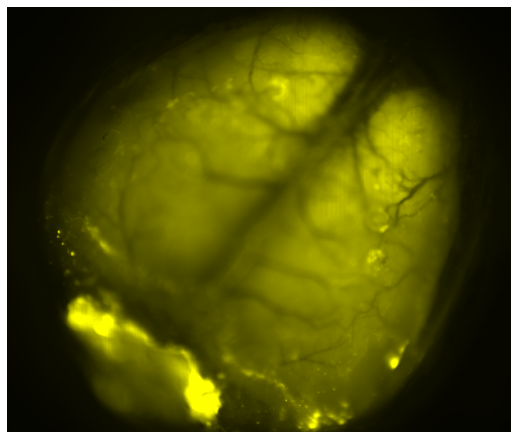

<Figure size 432x288 with 0 Axes>

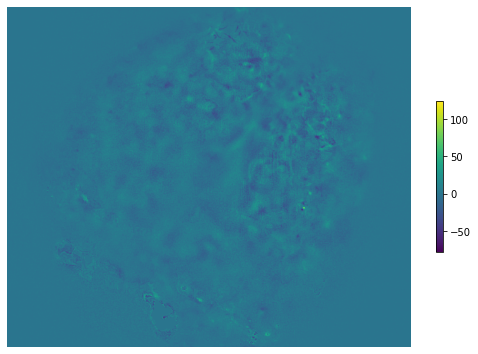

In [22]:
%matplotlib inline
check = np.stack([mov[:,0].mean(axis = 0) + frames_average[0],
                  dat[:500,0].mean(axis = 0)])
plt.figure();
imshow_noborder(two_chan_to_rgb(check));
plt.figure();
imshow_noborder(np.diff(check,axis=0).squeeze());
plt.colorbar(shrink = 0.3);

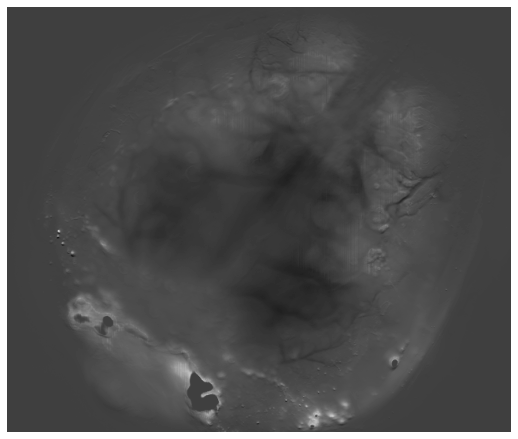

In [29]:
imshow_noborder(reconstruct(U,SVT[:,100],dims = dat.shape[-2:]).squeeze(),cmap = 'gray');
